In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd


pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100


import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import rc


import plotly.express as px

from paths import *
from scripts import vis_simulaCovid

import yaml


## SimulaCovid API ('http://datasource.coronacidades.org:7000/')
- br/states/rt
- br/cities/embaixadores
- br/cities/cnes
- world/owid/heatmap
- br/cities/farolcovid/main
- br/cities/rt
- br/cities/simulacovid/main
- br/cities/cases/full
- br/states/farolcovid/main


### RT

In [11]:
#load br cities
geo_sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
# cols = ['geocodigo','nome_mesorregiao','geometry']
cols = ['geocodigo','nome_mesorregiao','nome_municipio']
geo_sp = geo_sp[cols]

In [12]:
#load state data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/states/rt'

ds = pd.read_csv(f'{url}{data}')

ds['last_updated'] = pd.to_datetime(ds['last_updated'])

sp = ds[ds['state']=='SP']
sp = sp.rename(columns={'state':'city_id'})
sp['nome_mesorregiao'] = 'SP'
sp['nome_municipio']   = 'Estado de SP'

rj = ds[ds['state']=='RJ']
rj = rj.rename(columns={'state':'city_id'})
rj['nome_mesorregiao'] = 'RJ'
rj['nome_municipio']   = 'Estado do RJ'

mg = ds[ds['state']=='MG']
mg = mg.rename(columns={'state':'city_id'})
mg['nome_mesorregiao'] = 'MG'
mg['nome_municipio']   = 'Estado de MG'

am = ds[ds['state']=='AM']
am = am.rename(columns={'state':'city_id'})
am['nome_mesorregiao'] = 'AM'
am['nome_municipio']   = 'Estado de AM'

In [30]:
#load cities data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/cities/rt'

df = pd.read_csv(f'{url}{data}')

df['last_updated'] = pd.to_datetime(df['last_updated'])


dd = df.merge(geo_sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd.head()

regiao = 'Vale do Paraíba Paulista'
mask = (dd['nome_mesorregiao']==regiao)
vale = dd[mask]
# vale = vale[vale['city_id'].notnull()]

mask = (dd['nome_municipio']=='São Paulo')
sp_city = dd[mask]


vale = pd.concat([vale,sp_city], 0)
vale = pd.concat([vale,sp], 0)
vale = pd.concat([vale,rj], 0)
vale = pd.concat([vale,mg], 0)
# vale = pd.concat([vale,am], 0)



In [5]:
def plot_rt_final(df_final,col,N_COLS):
    
    N_ROWS = int(np.ceil(len(df_final[col].unique()) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=400)

    for i, (city, result) in enumerate(df_final.groupby(col,sort=False)):
        ax = axes.flat[i]
        vis_simulaCovid.plot_rt(result, ax, city)
    fig.tight_layout()
    fig.set_facecolor('w')
    
    return fig

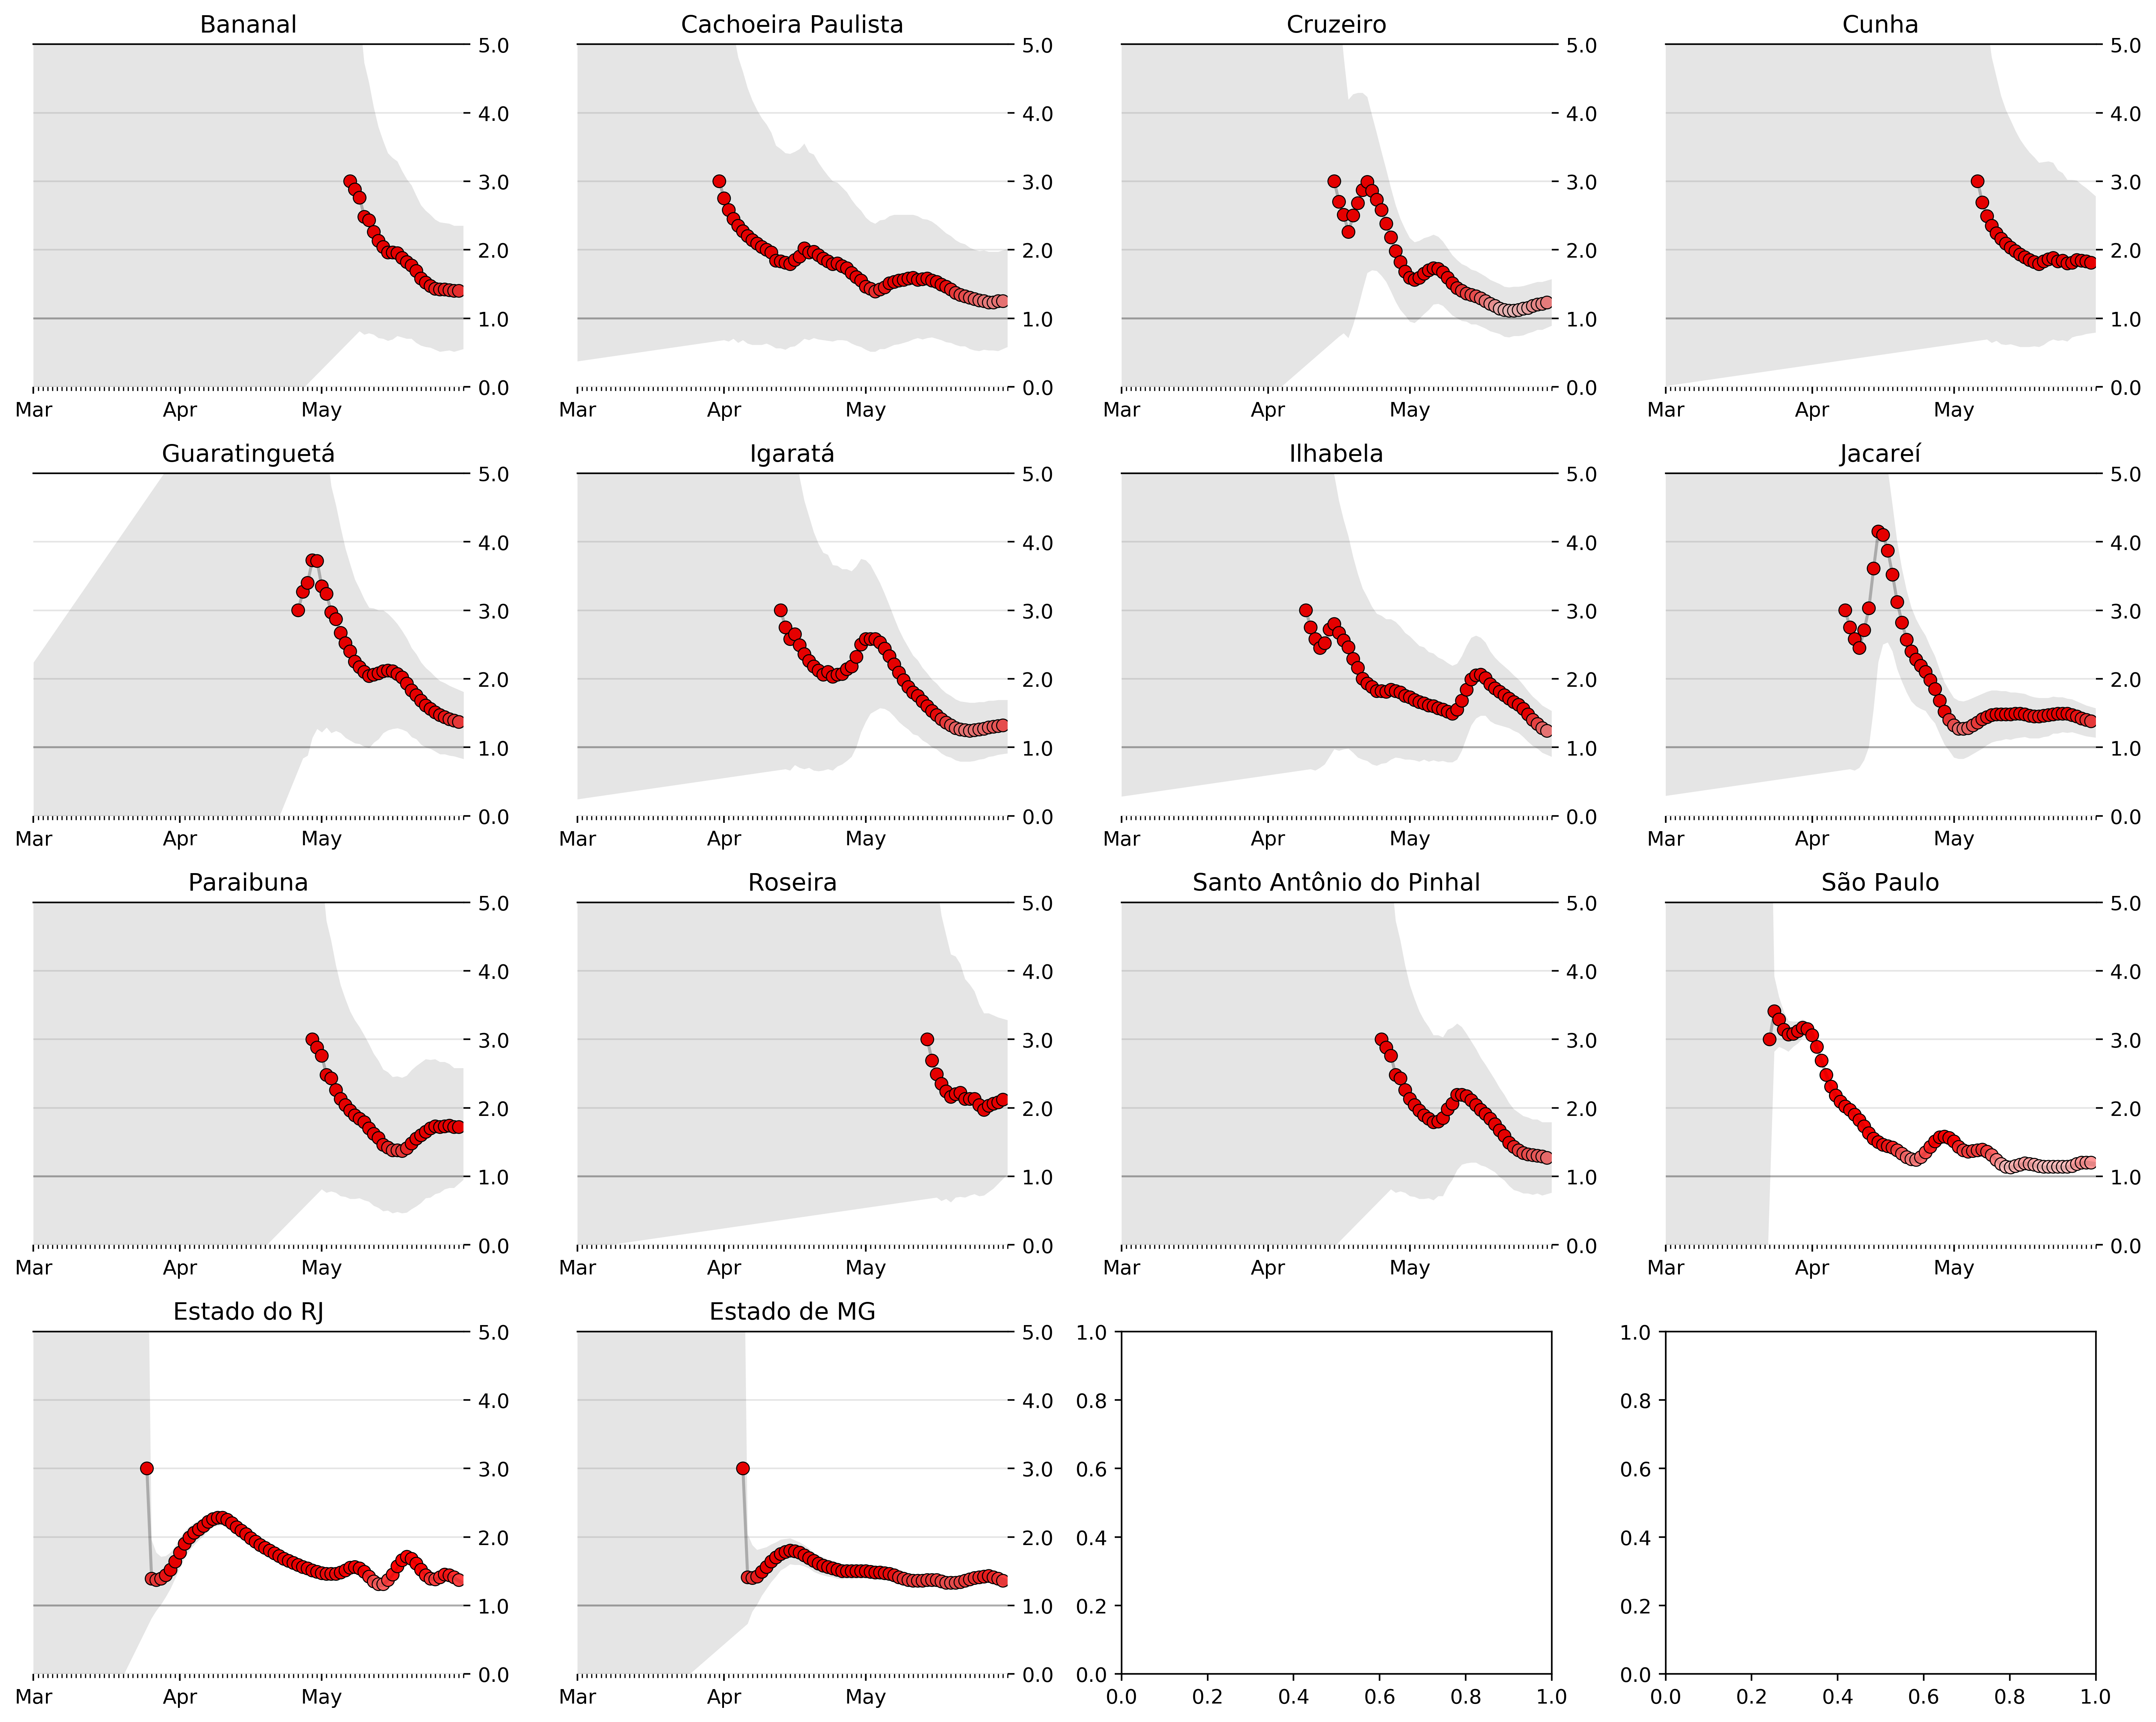

In [6]:
fig = plot_rt_final(vale,'nome_municipio',4)

fig.savefig("/home/m/Downloads/cidades.pdf", bbox_inches='tight')

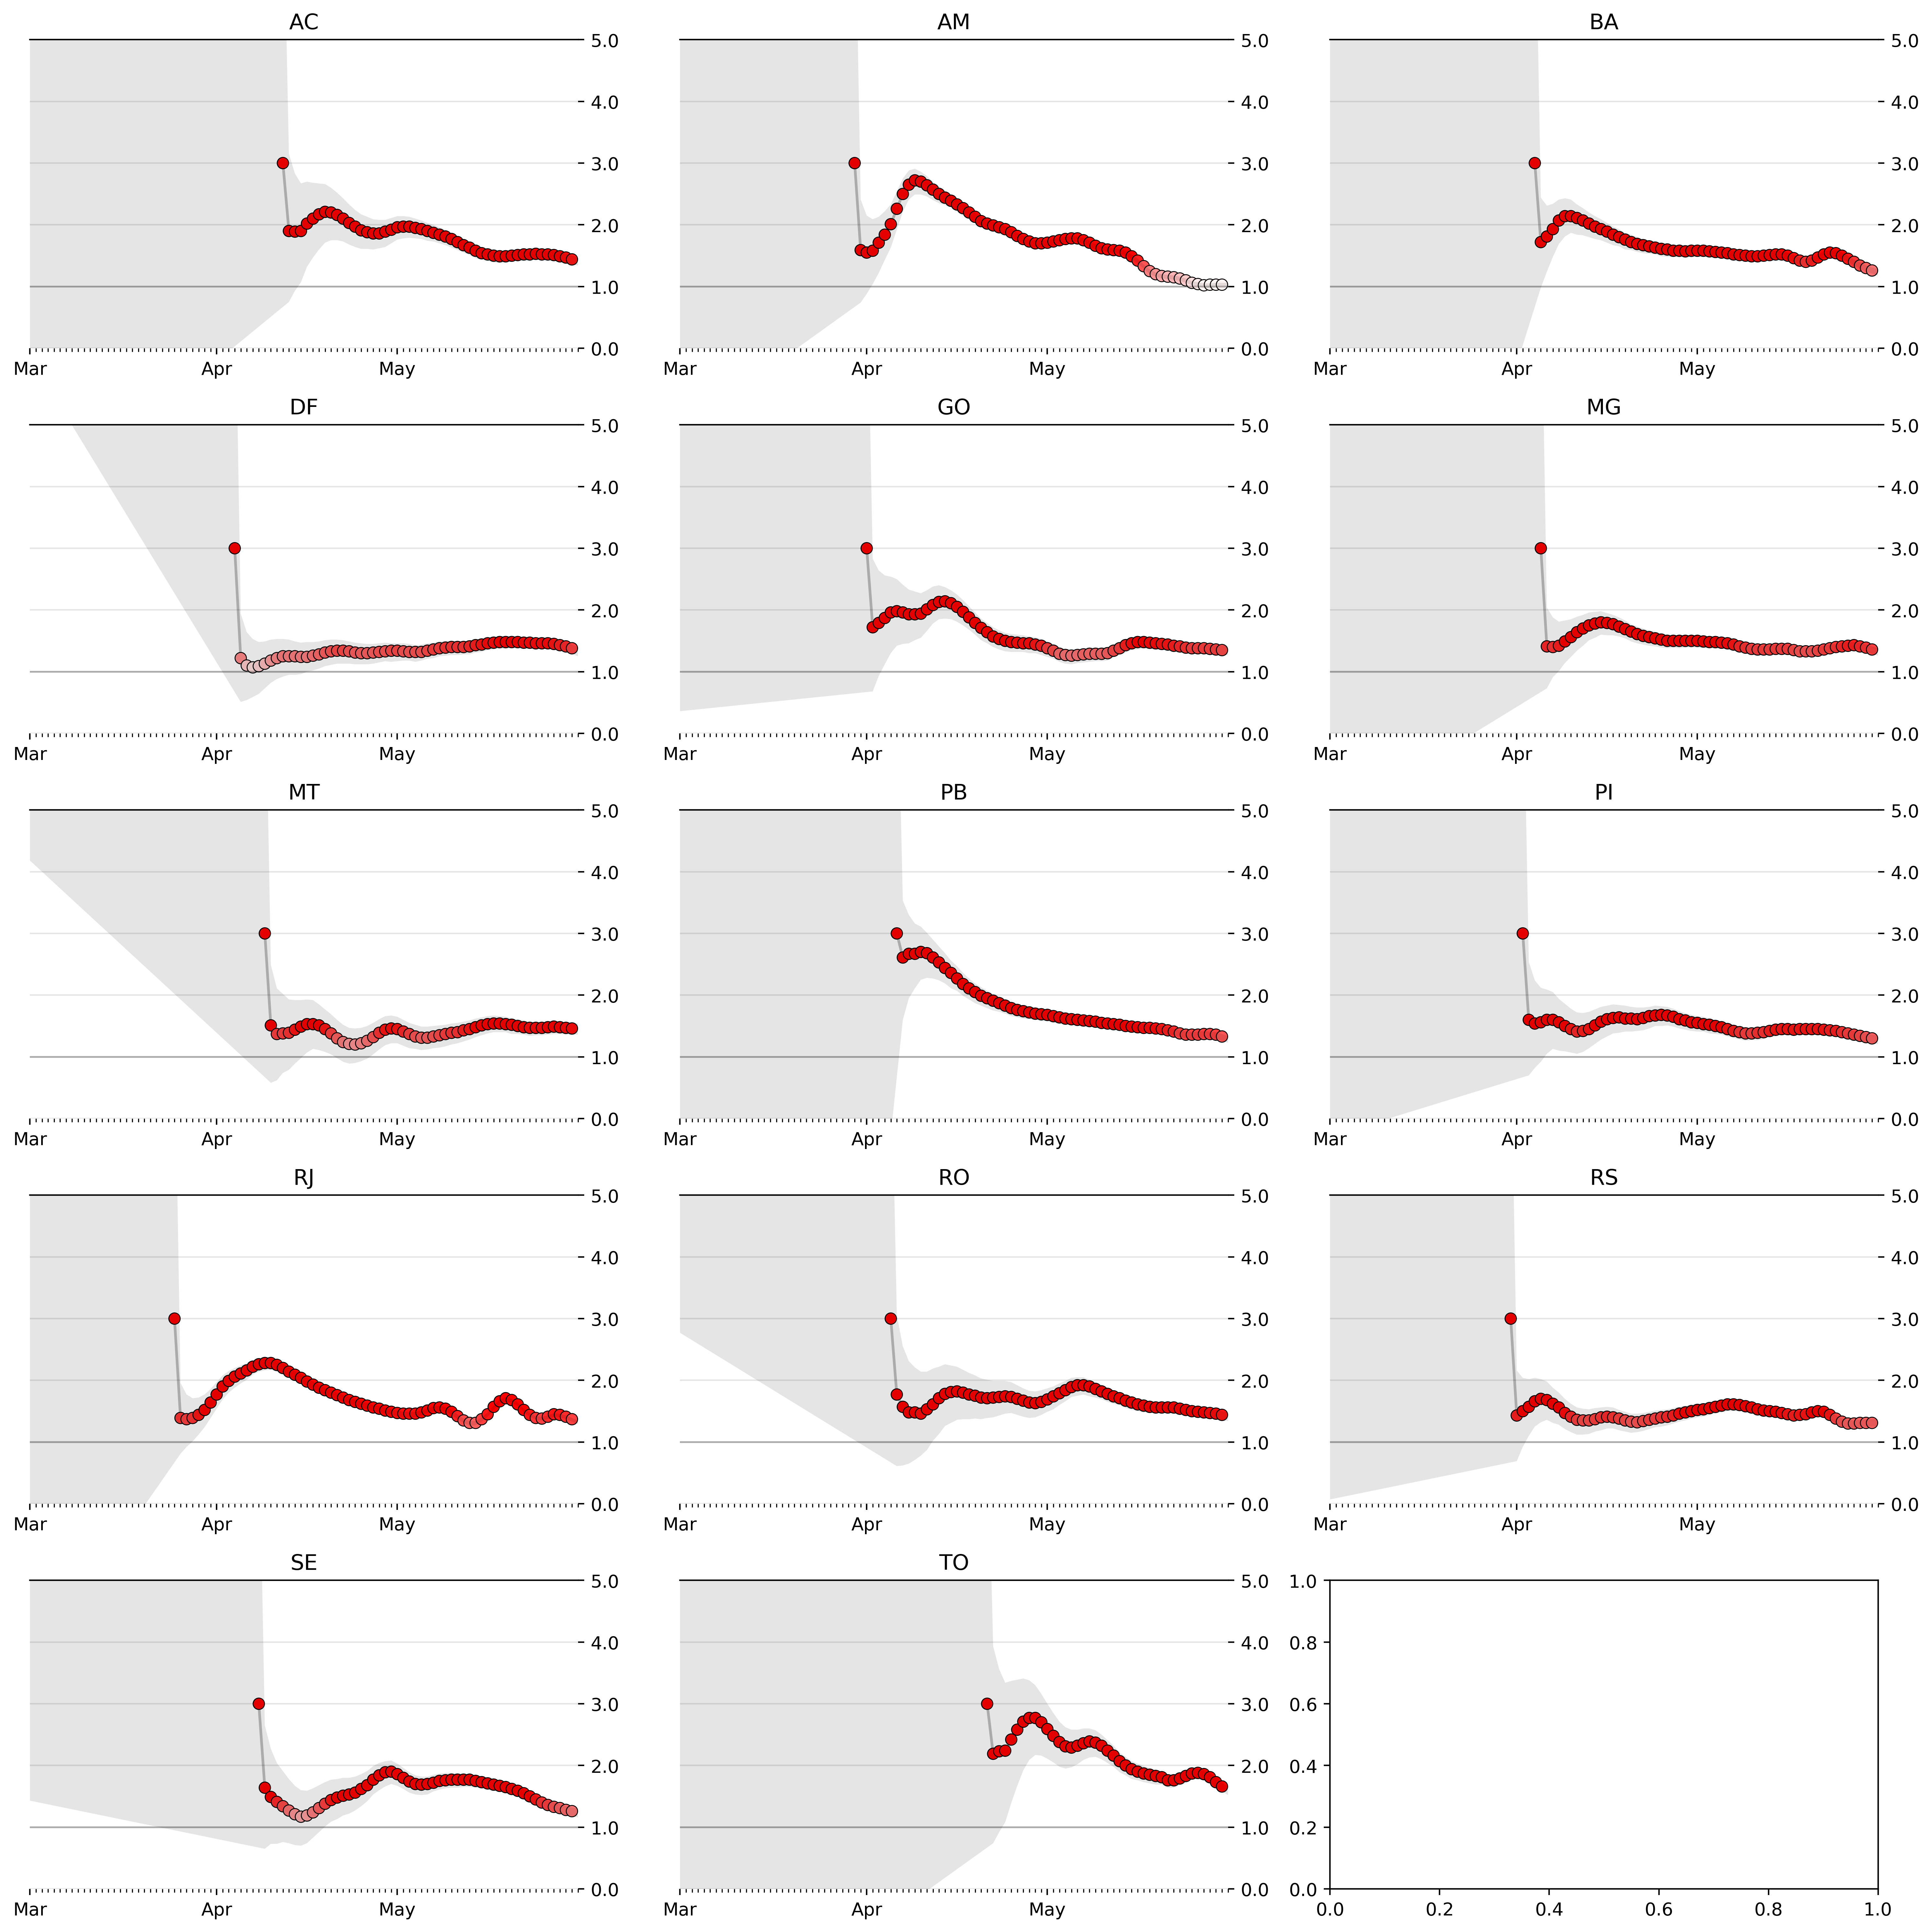

In [7]:
fig = plot_rt_final(ds,'state',3)
fig.savefig("/home/m/Downloads/estados.pdf", bbox_inches='tight')

## Selected cities

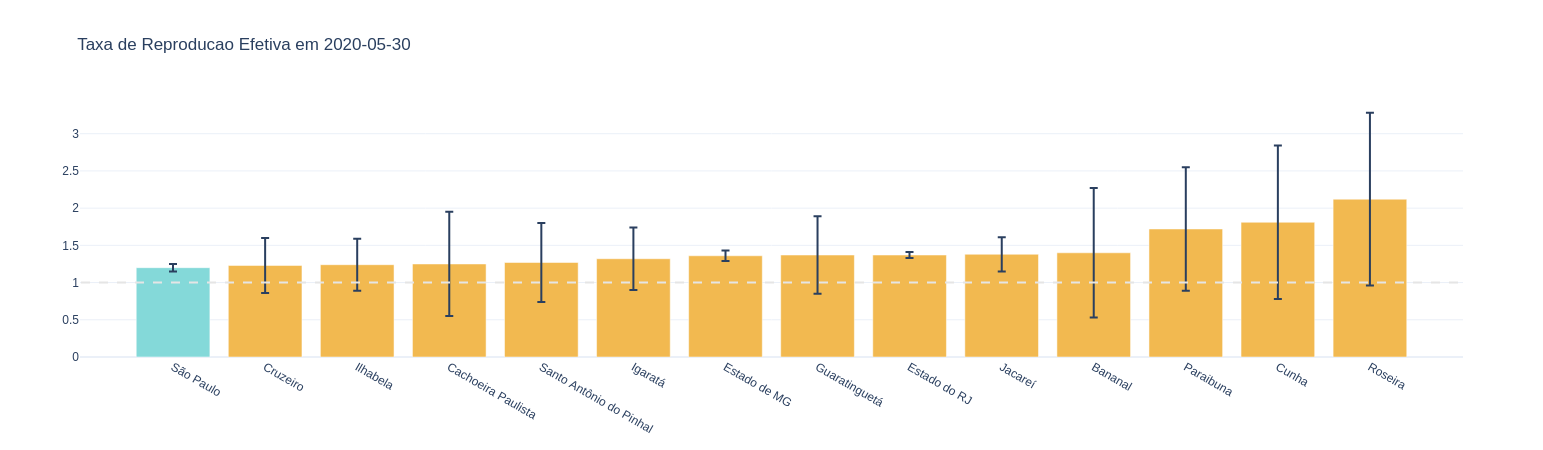

In [8]:
## Rt for most recent date
max_date = max(vale['last_updated'])
vale_last_date = vale[vale['last_updated']==max_date].sort_values(by='Rt_most_likely')
last_date = max_date.strftime('%Y-%m-%d')
vis_simulaCovid.plot_rt_bars(vale_last_date, title= f'Taxa de Reproducao Efetiva em {last_date}', place_type='nome_municipio')

In [9]:
vale_last_date['nome_municipio']

6330                  São Paulo
1891                   Cruzeiro
2615                   Ilhabela
1252         Cachoeira Paulista
5846    Santo Antônio do Pinhal
2563                    Igaratá
340                Estado de MG
2203              Guaratinguetá
573                Estado do RJ
3308                    Jacareí
675                     Bananal
4244                  Paraibuna
1916                      Cunha
5352                    Roseira
Name: nome_municipio, dtype: object

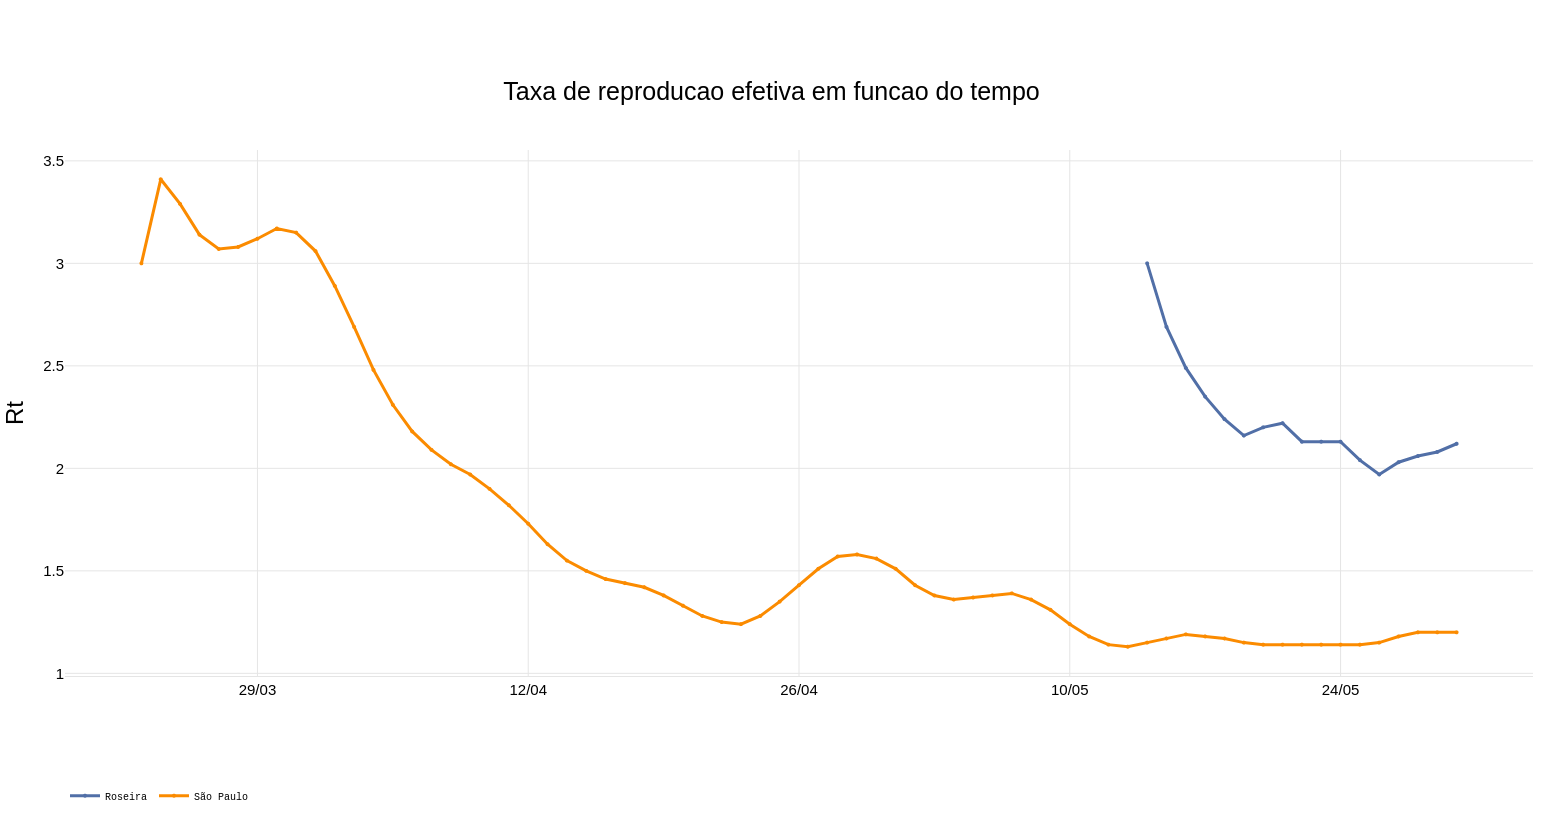

In [10]:
municipios = ['São Paulo', 'Estado de SP', 'Taubaté', 'São José dos Campos', 'Jambeiro','Roseira','Ubatuba']
vale_filtered = vale[vale['nome_municipio'].isin(municipios)]



themes = yaml.load(open('../themes/themes_simulaCovid.yaml', 'r'), Loader=yaml.FullLoader)
themes = themes['rt_selected_cities']
fig = vis_simulaCovid.plot_rt_plotly(vale_filtered, themes)

fig

## RT MAP

In [ ]:
#load br cities
sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
cols = ['geocodigo','nome_mesorregiao','geometry']
sp = sp[cols]

In [ ]:
#load data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/cities/farolcovid/main'

df = pd.read_csv(f'{url}{data}')

dd = df.merge(sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd = gpd.GeoDataFrame(dd)


regiao = 'Vale do Paraíba Paulista'
mask = dd['nome_mesorregiao']==regiao
vale = dd[mask]

vale = gpd.GeoDataFrame(vale)

In [116]:
def plot_map(dd,var):
    fig = plt.figure(figsize=(25,25))
    ax  = fig.add_subplot(1,1,1)
    ax.set_title(f'{var}', fontsize=23)


    missings={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    }


    # dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[0.75,1]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,100,500,1000,10000]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[1,5,10,50,100,500,1000,3000]},missing_kwds=missings )
    dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,30,50,70]},missing_kwds=missings )

#     dd.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" ,missing_kwds=missings, scheme='quantiles',k=30)

    ax.axis('off')


    plt.rc('legend',fontsize='large')

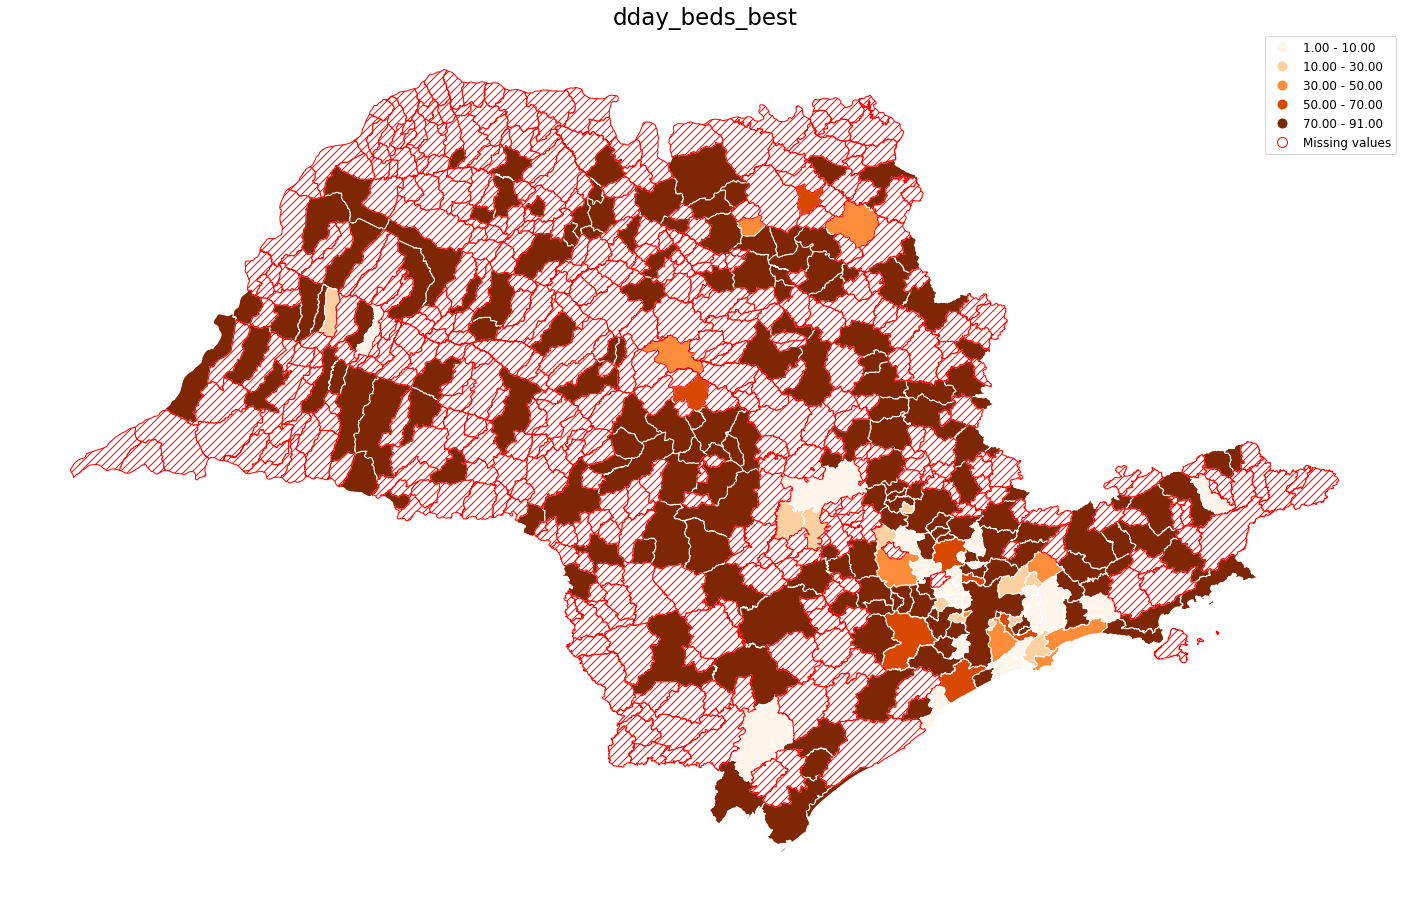

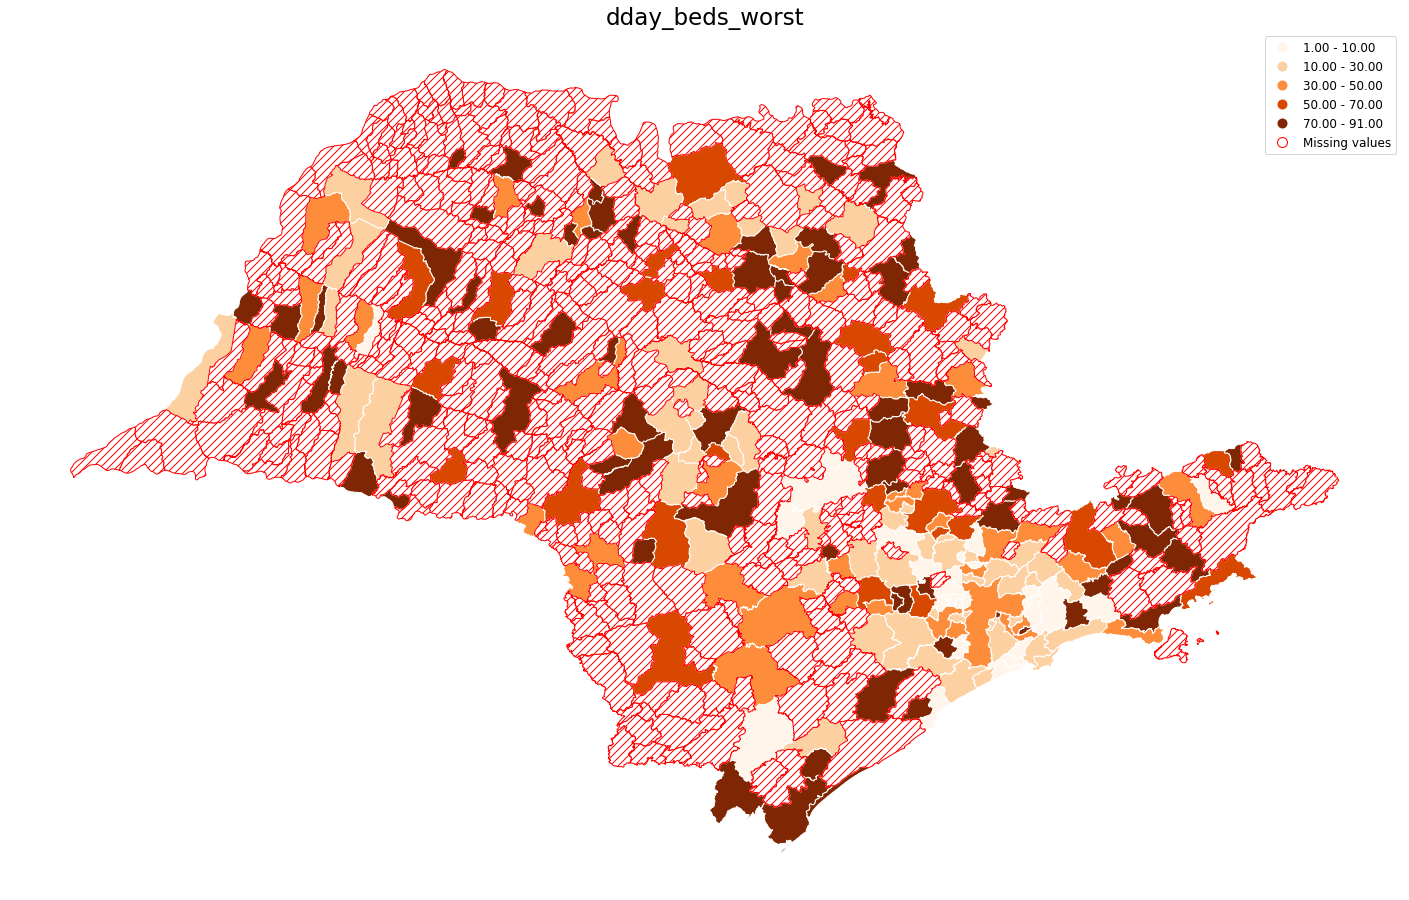

In [117]:
var = 'dday_beds_best'

plot_map(dd,var)


var = 'dday_beds_worst'

plot_map(dd,var)



# var = 'rt_10days_ago_avg'

# plot_map(dd,var)

# var = 'rt_ratio_week_avg'

# plot_map(dd,var)